In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

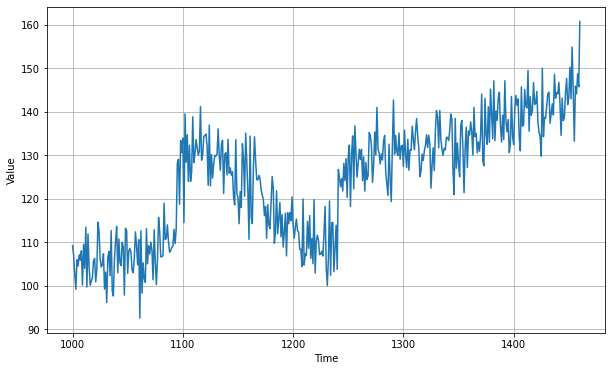

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


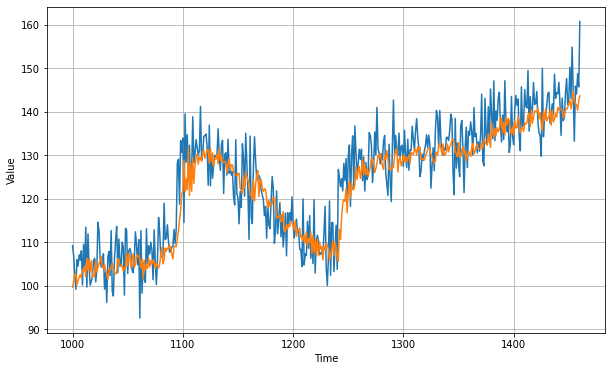

In [7]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.696446

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # change lr based on epoch number
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

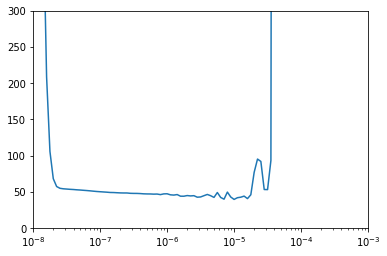

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
# and we'll see a chart like this. 
# The y-axis shows us the loss for that epoch and the x-axis shows us the learning rate. 
# We can then try to pick the lowest point of the curve where 
# it's still relatively stable like this, and that's right around 7 times 10 to the -6.

In [14]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=2)

Epoch 1/500
31/31 - 0s - loss: 779.3938
Epoch 2/500
31/31 - 0s - loss: 106.6607
Epoch 3/500
31/31 - 0s - loss: 67.2354
Epoch 4/500
31/31 - 0s - loss: 53.1100
Epoch 5/500
31/31 - 0s - loss: 60.0783
Epoch 6/500
31/31 - 0s - loss: 48.4002
Epoch 7/500
31/31 - 0s - loss: 60.5194
Epoch 8/500
31/31 - 0s - loss: 49.8262
Epoch 9/500
31/31 - 0s - loss: 45.4683
Epoch 10/500
31/31 - 0s - loss: 54.6306
Epoch 11/500
31/31 - 0s - loss: 67.4646
Epoch 12/500
31/31 - 0s - loss: 133.3871
Epoch 13/500
31/31 - 0s - loss: 56.9628
Epoch 14/500
31/31 - 0s - loss: 69.9031
Epoch 15/500
31/31 - 0s - loss: 42.0602
Epoch 16/500
31/31 - 0s - loss: 44.0241
Epoch 17/500
31/31 - 0s - loss: 40.6584
Epoch 18/500
31/31 - 0s - loss: 43.0938
Epoch 19/500
31/31 - 0s - loss: 54.5143
Epoch 20/500
31/31 - 0s - loss: 44.6091
Epoch 21/500
31/31 - 0s - loss: 35.7763
Epoch 22/500
31/31 - 0s - loss: 39.3959
Epoch 23/500
31/31 - 0s - loss: 68.5358
Epoch 24/500
31/31 - 0s - loss: 45.9478
Epoch 25/500
31/31 - 0s - loss: 41.5696
Epoch 

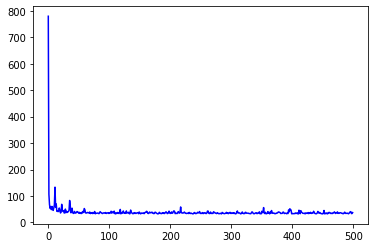

In [15]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[67.46464538574219, 133.38711547851562, 56.96281433105469, 69.90306854248047, 42.06022644042969, 44.024085998535156, 40.65842056274414, 43.093807220458984, 54.51433563232422, 44.60906219482422, 35.776336669921875, 39.395938873291016, 68.5357666015625, 45.94783020019531, 41.5695915222168, 44.69815444946289, 35.832733154296875, 35.84965896606445, 50.413719177246094, 37.04994201660156, 42.236087799072266, 37.648738861083984, 39.92707824707031, 40.96074295043945, 45.51558303833008, 83.01185607910156, 63.535789489746094, 36.474220275878906, 38.097557067871094, 53.82655334472656, 37.28666687011719, 34.01880645751953, 34.90841293334961, 41.45799255371094, 35.80577087402344, 35.221961975097656, 37.36868667602539, 40.91530990600586, 40.467247009277344, 37.84759521484375, 34.58617401123047, 38.1848258972168, 34.17789840698242, 35.715885162353516, 33.40437316894531, 38.237396240234375, 35.84002685546875, 41.85921859741211, 37.64376449584961, 52.55242919921875, 47.73809814453125, 36.02657318115234

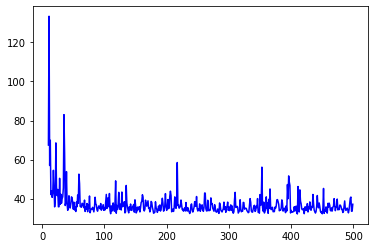

In [16]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

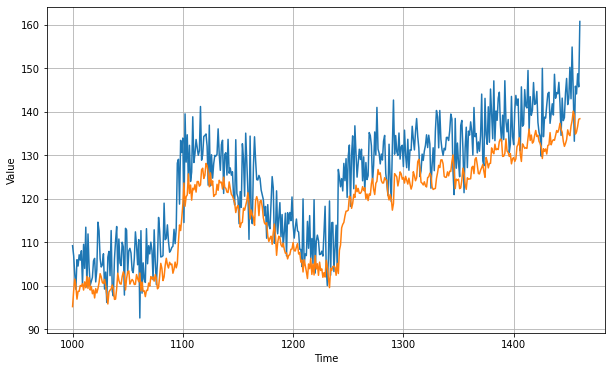

In [17]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.455365